# Oceanography Notebook

In [1]:
import scipy.io
import pyproj
import matplotlib.dates

from pyproj   import Proj
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import pandas            as pd
import numpy             as np
import datetime          as dt

import plotly.express as px

# Oceanography

DAS data from the 1 day of recotrding on the south cable has been processed using block averaging to give time samples every second and channels every 20m.

In the cell below we load that data and first plot all the data and a zoom of near shore data over 30 minutes.


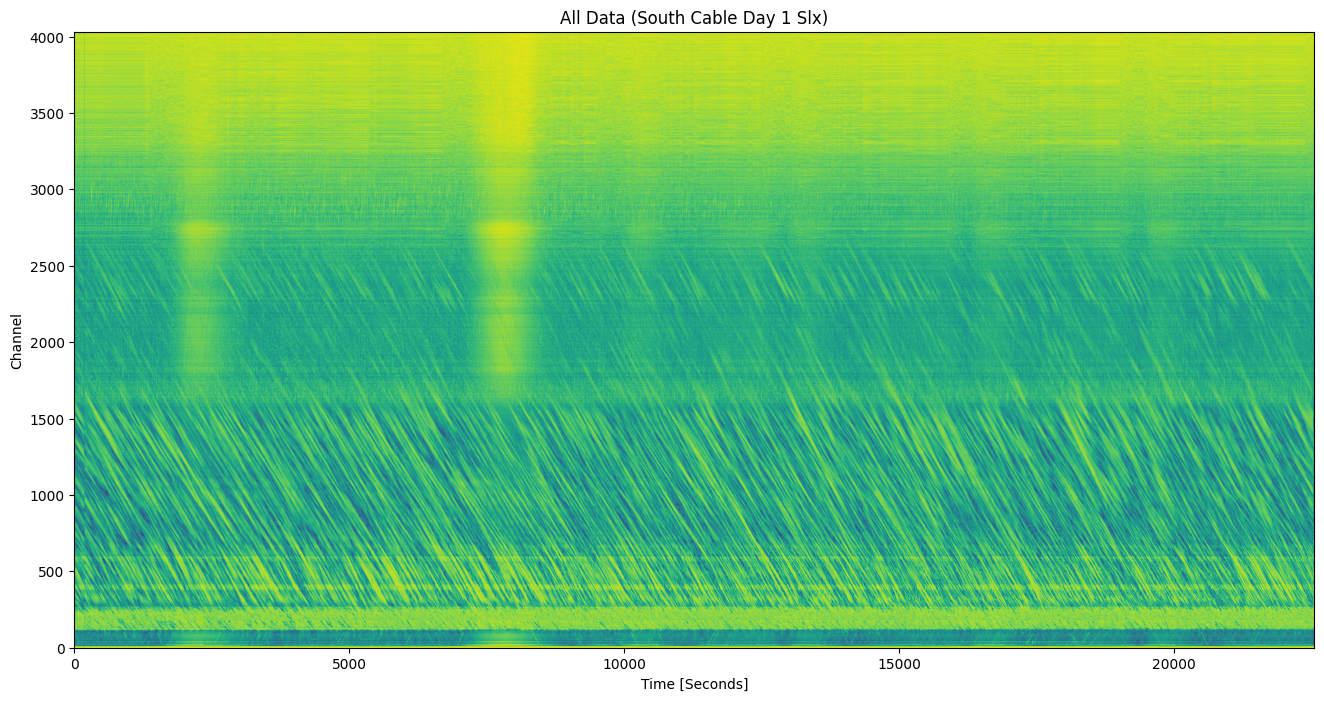

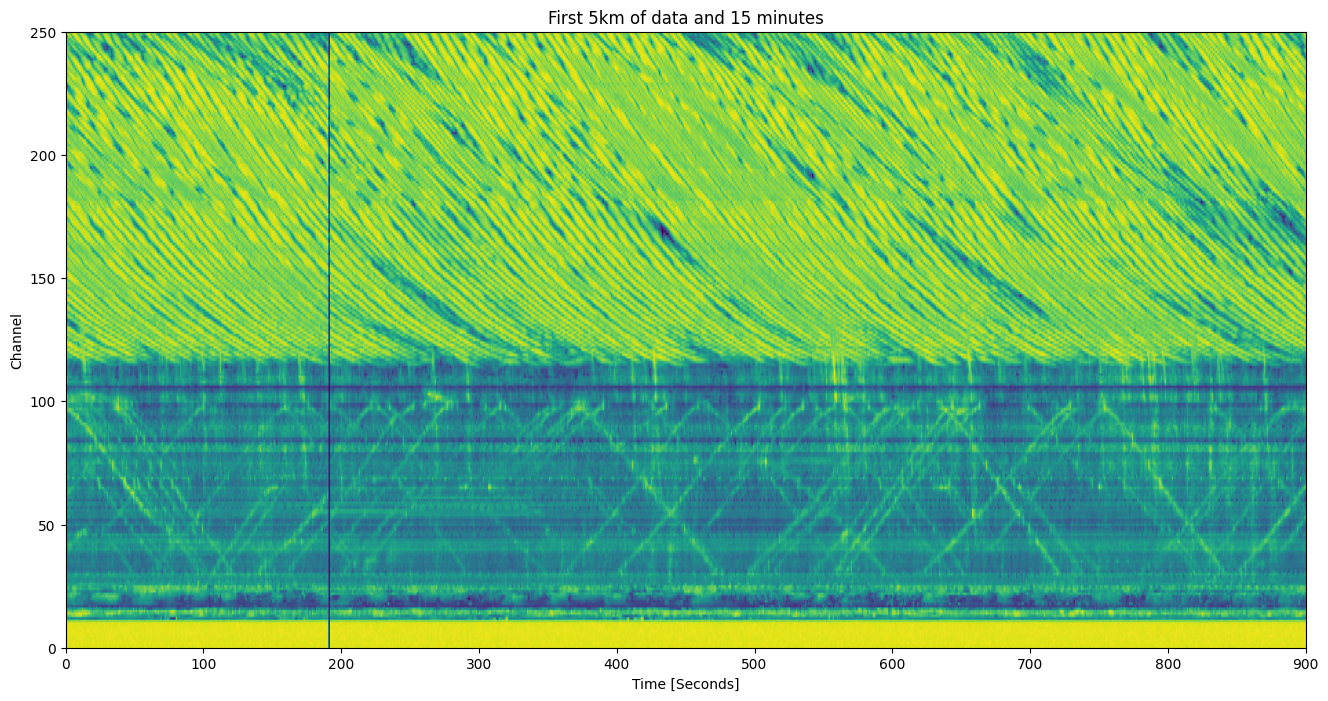

In [3]:
samplingFrequency =  1.0 # 1Hertz
spacing           = 20.0 # meters

dasData = scipy.io.matlab.loadmat(r'../../Data/Oceanography/Slx_South_20211101_BlockReduce10x200.mat')['data']

plt.figure(figsize=(16,8))
plt.imshow(np.log10(((dasData.T - np.min(dasData,axis=1))/np.max(dasData,axis=1)).T+0.01),
           aspect='auto')
plt.xlabel('Time [Seconds]')
plt.ylabel('Channel')
plt.ylim(0,dasData.shape[0])
plt.xlim(0,dasData.shape[1])
plt.title('All Data (South Cable Day 1 Slx)')
plt.show()

plt.figure(figsize=(16,8))
plt.imshow(np.log10(((dasData.T - np.min(dasData,axis=1))/np.max(dasData,axis=1)).T+0.01),
           aspect='auto')
plt.ylim(0,250)
plt.xlim(0,15*60)
plt.xlabel('Time [Seconds]')
plt.ylabel('Channel')
plt.title('First 5km of data and 15 minutes')
plt.show()


## Load Cable Geometry

In the cell below we load the station coordinates for the north and south cables and plot them

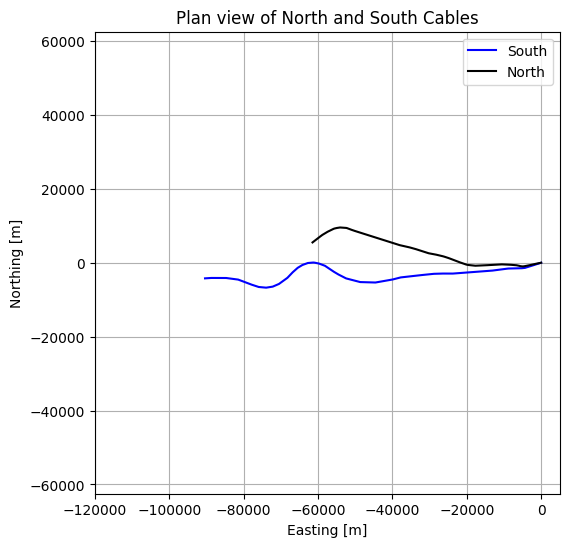

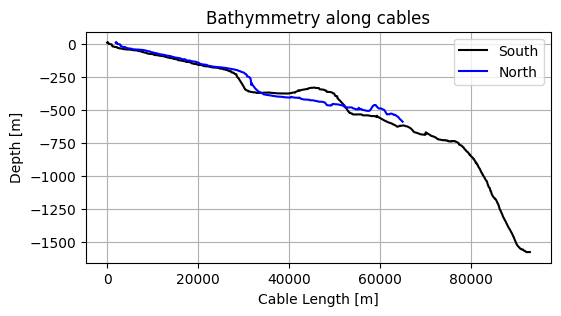

In [6]:
df_NorthCable= pd.read_csv(r'../../Documentation/CableGeometries/NorthCable_Geometry.csv')
df_SouthCable= pd.read_csv(r'../../Documentation/CableGeometries/SouthCable_Geometry.csv')

plt.figure(figsize=(6,6))
plt.plot(df_SouthCable['Easting']-df_SouthCable['Easting'][0],
         df_SouthCable['Northing']-df_SouthCable['Northing'][0],'b-',label='South')
plt.plot(df_NorthCable['Easting']-df_SouthCable['Easting'][0],
         df_NorthCable['Northing']-df_SouthCable['Northing'][0],'k-',label='North')
plt.legend()
plt.grid()
plt.xlim(-120.e3,5e3)
plt.ylim(-62.5e3,62.5e3)
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.title('Plan view of North and South Cables')
plt.show()

plt.figure(figsize=(6,3))
plt.plot(df_SouthCable['Station']*2,df_SouthCable['Depth'],'k-',label='South')
plt.plot(df_NorthCable['Station']*2,df_NorthCable['Depth'],'b-',label='North')
plt.legend()
plt.grid()
plt.xlabel('Cable Length [m]')
plt.ylabel('Depth [m]')
plt.title('Bathymmetry along cables')
plt.show()


# Buoy Data

### Buoy 46050 is located about 60 km south of the South Cable.
#### We can use this buoy data to determine a number of different factors about the conditions near the cables.
#### This buoy location in comparison to the cables is plotted below.

Recorded data include:

-  Wind direction (the direction the wind is coming from in degrees clockwise from true N) during the same period used for WSPD. See Wind Averaging Methods

-  Wind speed (m/s) averaged over an eight-minute period for buoys and a two-minute period for land stations. Reported Hourly. See Wind Averaging Methods.

-  Peak 5 or 8 second gust speed (m/s) measured during the eight-minute or two-minute period. The 5 or 8 second period can be determined by payload, See the Sensor Reporting, Sampling, and Accuracy section.

-  Significant wave height (meters) is calculated as the average of the highest one-third of all of the wave heights during the 20-minute sampling period. See the Wave Measurements section.

-  Dominant wave period (seconds) is the period with the maximum wave energy. See the Wave Measurements section.

-  Average wave period (seconds) of all waves during the 20-minute period. See the Wave Measurements section.

-  The direction from which the waves at the dominant period (DPD) are coming. The units are degrees from true North, increasing clockwise, with North as 0 (zero) degrees and East as 90 degrees. See the Wave Measurements section.

-  Sea level pressure (hPa). For C-MAN sites and Great Lakes buoys, the recorded pressure is reduced to sea level using the method described in NWS Technical Procedures Bulletin 291 (11/14/80). ( labeled BAR in Historical files).

-  Air temperature (Celsius). For sensor heights on buoys, see Hull Descriptions. For sensor heights at C-MAN stations, see C-MAN Sensor Locations"

-  Sea surface temperature (Celsius). For buoys the depth is referenced to the hull's waterline. For fixed platforms it varies with tide, but is referenced to, or near Mean Lower Low Water (MLLW).

-  Dewpoint temperature taken at the same height as the air temperature measurement.

-  Station visibility (nautical miles). Note that buoy stations are limited

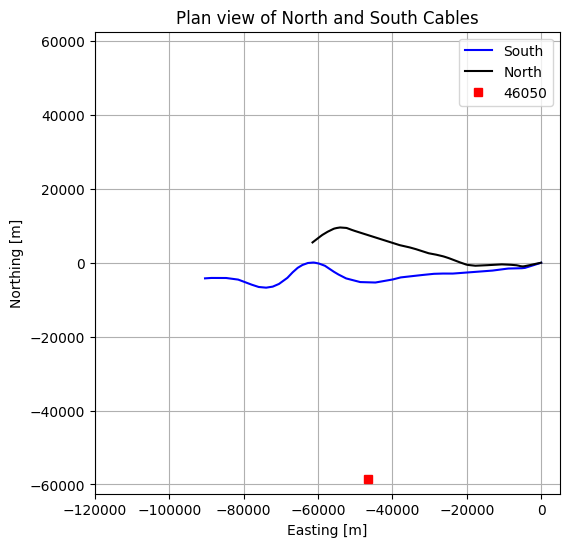

In [7]:
# https://www.ndbc.noaa.gov/

Buoy46050 = (44.669,-124.546) # Northing Easting

myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

x,y = myProj(Buoy46050[1],Buoy46050[0])

df_Standard = pd.read_csv(r'../../Documentation/BuoyData/Station46050_2021.txt',delim_whitespace=True,skiprows=[1])

dateTimes = []
for i,row in df_Standard.iterrows():
    yy = str(int(row['#YY']))
    mm = str(int(row['MM'])).zfill(2)
    dd = str(int(row['DD'])).zfill(2)
    H  = str(int(row['hh'])).zfill(2)
    M  = str(int(row['mm'])).zfill(2)
    
    dateTimes.append( pd.to_datetime(str(yy+mm+dd+' '+H+':'+M)) )
    
df_Standard['DateTime'] = np.array(dateTimes)

description =\
["WDIR","Wind direction (the direction the wind is coming from in degrees clockwise from true N) during the same period used for WSPD. See Wind Averaging Methods",\
"WSPD","Wind speed (m/s) averaged over an eight-minute period for buoys and a two-minute period for land stations. Reported Hourly. See Wind Averaging Methods.",\
"GST","Peak 5 or 8 second gust speed (m/s) measured during the eight-minute or two-minute period. The 5 or 8 second period can be determined by payload, See the Sensor Reporting, Sampling, and Accuracy section.",\
"WVHT","Significant wave height (meters) is calculated as the average of the highest one-third of all of the wave heights during the 20-minute sampling period. See the Wave Measurements section.",\
"DPD","Dominant wave period (seconds) is the period with the maximum wave energy. See the Wave Measurements section.",\
"APD","Average wave period (seconds) of all waves during the 20-minute period. See the Wave Measurements section.",\
"MWD","The direction from which the waves at the dominant period (DPD) are coming. The units are degrees from true North, increasing clockwise, with North as 0 (zero) degrees and East as 90 degrees. See the Wave Measurements section.",\
"PRES","Sea level pressure (hPa). For C-MAN sites and Great Lakes buoys, the recorded pressure is reduced to sea level using the method described in NWS Technical Procedures Bulletin 291 (11/14/80). ( labeled BAR in Historical files)",\
"ATMP","Air temperature (Celsius). For sensor heights on buoys, see Hull Descriptions. For sensor heights at C-MAN stations, see C-MAN Sensor Locations",
"WTMP","Sea surface temperature (Celsius). For buoys the depth is referenced to the hull's waterline. For fixed platforms it varies with tide, but is referenced to, or near Mean Lower Low Water (MLLW).",\
"DEWP","Dewpoint temperature taken at the same height as the air temperature measurement.",\
"VIS","Station visibility (nautical miles). Note that buoy stations are limited to reports from 0 to 1.6 nmi.",\
#"PTDY","Pressure Tendency is the direction (plus or minus) and the amount of pressure change (hPa)for a three hour period ending at the time of observation. (not in Historical files)",\
"TIDE","The water level in feet above or below Mean Lower Low Water (MLLW)."]
description = np.array(description).reshape(-1,2)

df_Standard.describe()

plt.figure(figsize=(6,6))
plt.plot(df_SouthCable['Easting']-df_SouthCable['Easting'][0],
         df_SouthCable['Northing']-df_SouthCable['Northing'][0],'b-',label='South')
plt.plot(df_NorthCable['Easting']-df_SouthCable['Easting'][0],
         df_NorthCable['Northing']-df_SouthCable['Northing'][0],'k-',label='North')
plt.plot(x-df_SouthCable['Easting'][0],
         y-df_SouthCable['Northing'][0],'rs',label='46050')
plt.legend()
plt.grid()
plt.xlim(-120.e3,5e3)
plt.ylim(-62.5e3,62.5e3)
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.title('Plan view of North and South Cables')
plt.show()

# Displaying the Buoy data
Here we plot some data from the buoy over the DAS recording period

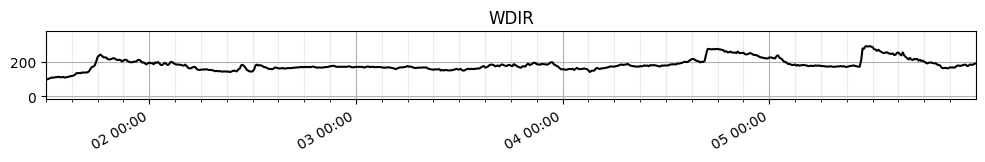

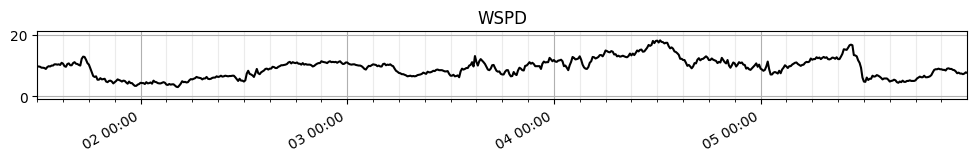

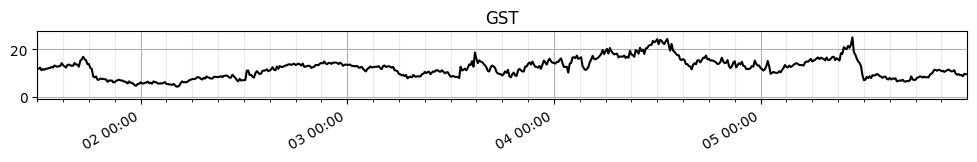

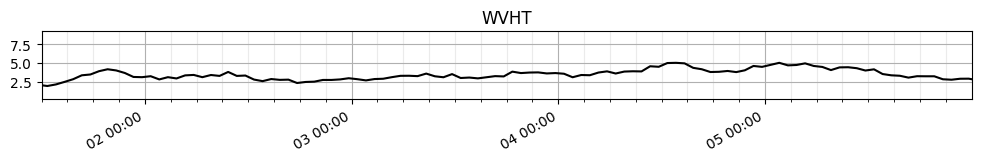

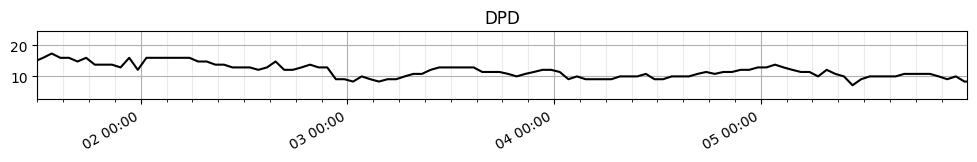

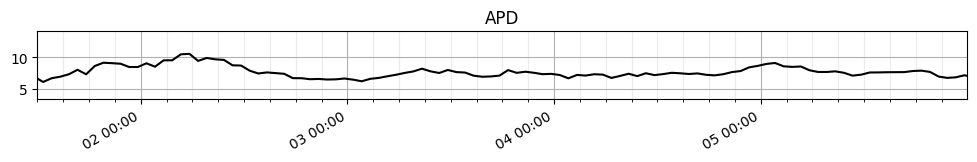

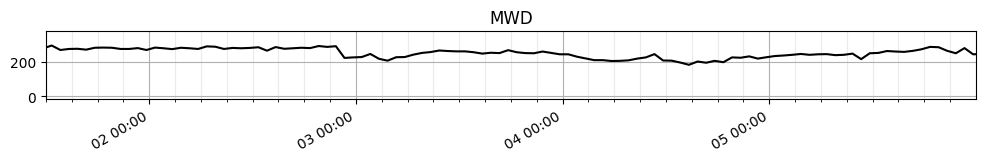

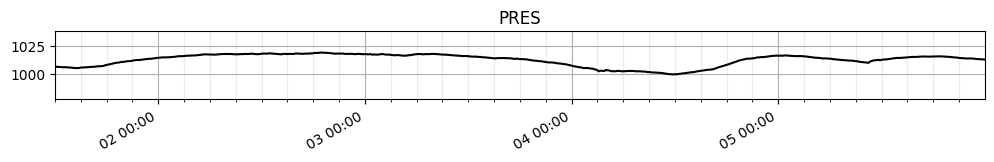

Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).


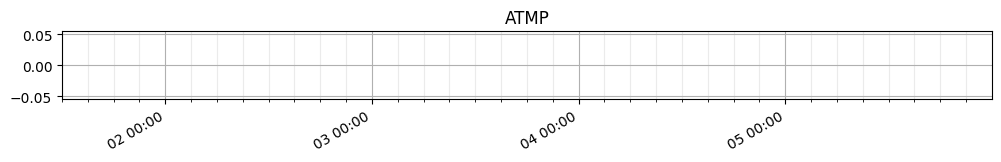

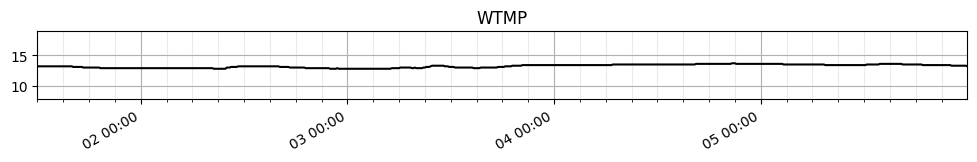

Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).


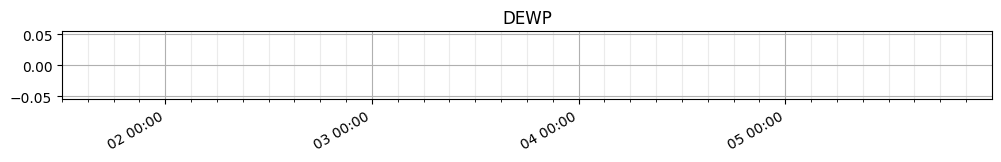

Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).


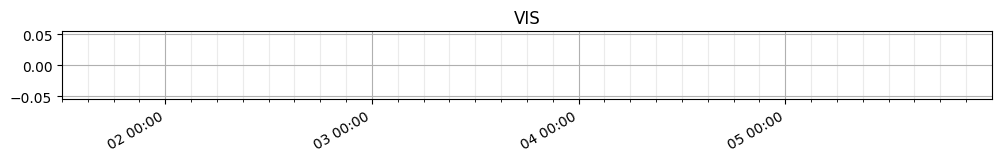

Locator attempting to generate 3654 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).


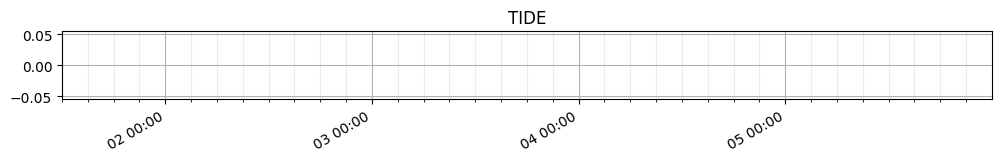

In [8]:
xStart = datetime.strptime('20211101_150000','%Y%m%d_%H%M%S')
xStop  = datetime.strptime('20211105_150000','%Y%m%d_%H%M%S')
xStart = matplotlib.dates.date2num(xStart)
xStop  = matplotlib.dates.date2num(xStop)

for i,var in enumerate(description[:,0]):
    
    plt.figure(figsize=(12,1))

    mask = (df_Standard[var] != 99) & (df_Standard[var] != 999)& (df_Standard[var] != 9999)
    plt.plot_date(df_Standard['DateTime'][mask],df_Standard[var][mask],'k-')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    plt.gcf().autofmt_xdate()
    plt.xlim(mdates.date2num(dt.datetime.strptime('20211101_120000','%Y%m%d_%H%M%S')),
             mdates.date2num(dt.datetime.strptime('20211105_235959','%Y%m%d_%H%M%S')))
    plt.grid(which='major',alpha=1.00)
    plt.grid(which='minor',alpha=0.25)
    plt.title(var)
    plt.show()


## Tide Levels from Garibaldi Water Station NOAA

Tide levels are also available from the Garibaldi shore station 

In [9]:
df_Tides = pd.read_csv(r'../../Documentation/BuoyData/Noaa_Garibaldi_WaterLevels.csv')
dateTimes = []
for i,row in df_Tides.iterrows():
    
    dateTime = row['Date'] + " "+row['Time (GMT)']+":00"
    
    dateTimes.append( pd.to_datetime(dateTime,dayfirst=True) )

df_Tides['DateTime'] = np.array(dateTimes)

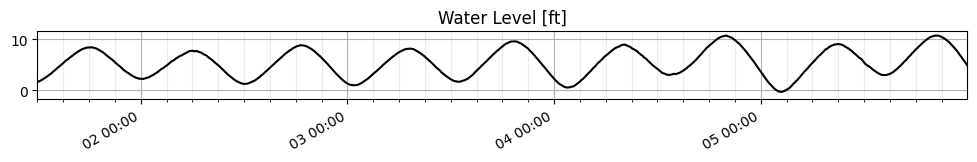

In [10]:
plt.figure(figsize=(12,1))

plt.plot_date(df_Tides['DateTime'],df_Tides['Verified (ft)'],'k-')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.xlim(mdates.date2num(dt.datetime.strptime('20211101_120000','%Y%m%d_%H%M%S')),
         mdates.date2num(dt.datetime.strptime('20211105_235959','%Y%m%d_%H%M%S')))
plt.grid(which='major',alpha=1.00)
plt.grid(which='minor',alpha=0.25)
plt.title('Water Level [ft]')
plt.show()
